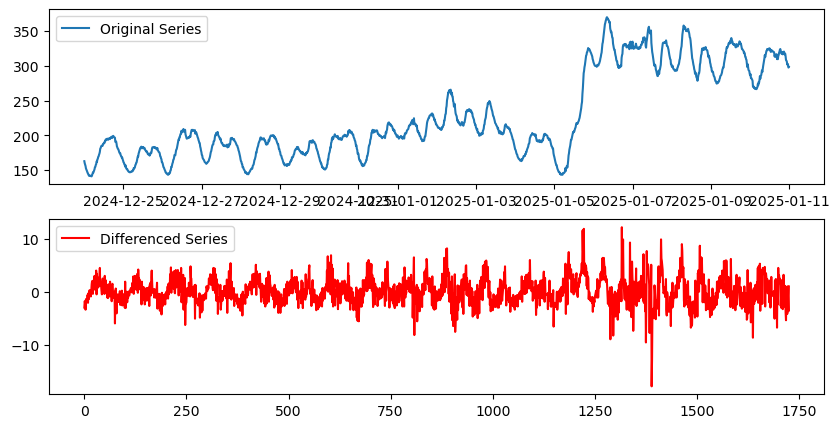

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                 1726
Model:              Restr. AutoReg(8)   Log Likelihood               -3820.588
Method:               Conditional MLE   S.D. of innovations              2.237
Date:                Sat, 01 Feb 2025   AIC                           7653.177
Time:                        16:40:29   BIC                           7685.870
Sample:                             8   HQIC                          7665.274
                                 1726                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0286      0.054      0.529      0.597      -0.077       0.134
y.L1           0.1519      0.023      6.601      0.000       0.107       0.197
y.L2           0.3037      0.024     12.833      0.0

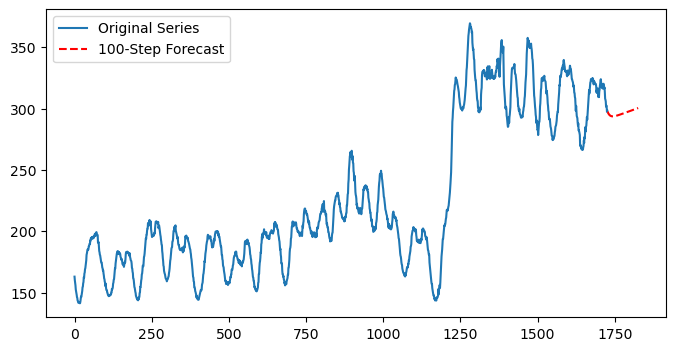

In [13]:
# H-Step Forecasting with the ARAR Algorithm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg

# Load dataset (example: monthly temperature anomalies)
data = pd.read_csv("ercot_load_data.csv", parse_dates=["date"], index_col="date")
y = data["values"]

# Differencing to remove trend
z = np.diff(y)

# Plot the original and differenced series
plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.plot(y, label="Original Series")
plt.legend()

plt.subplot(2,1,2)
plt.plot(z, label="Differenced Series", color="red")
plt.legend()

plt.savefig("arar_series_visualization.png")
plt.show()


### **Selecting Reduced Lag Set**

from statsmodels.tsa.stattools import acf

# Compute autocorrelation function
acf_vals = acf(z, nlags=20)
lags = [1, 2, 4, 8]  # Reduced lag set based on powers of 2

# Fit an autoregressive model using selected lags
model = AutoReg(z, lags=lags, old_names=False).fit()
print(model.summary())


### **Generating H-Step Forecasts**

# Generate H-step forecasts
h = 100  # Number of steps ahead
future_forecast = model.predict(start=len(z), end=len(z) + h - 1)

# Reverse differencing to reconstruct original scale
y_forecast = np.cumsum(future_forecast) + y.iloc[-1]

# Plot Forecast
plt.figure(figsize=(8, 4))
plt.plot(range(len(y)), y, label="Original Series")
plt.plot(range(len(y), len(y) + h), y_forecast, label=f"{h}-Step Forecast", linestyle="dashed", color="red")
plt.legend()

plt.savefig("arar_forecast_plot_fixed.png")
plt.show()



MAPE for ARAR: 0.0646
MAPE for ARIMA: 0.0964


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


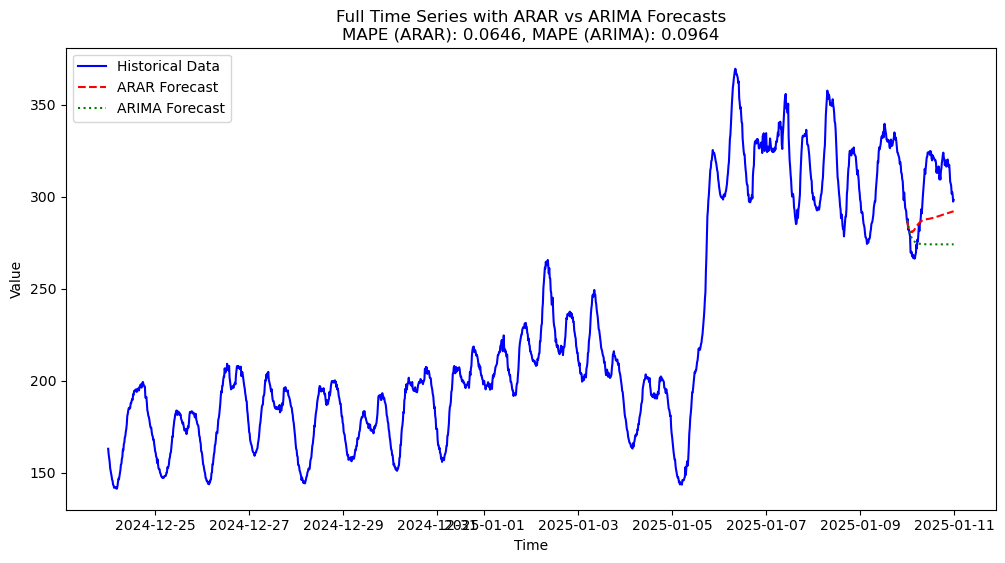

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf
from sklearn.metrics import mean_absolute_percentage_error

# Load dataset
# Load dataset
data = pd.read_csv("ercot_load_data.csv", parse_dates=["date"], index_col="date")
y = data["values"]
# Ensure the Date index has a proper frequency
data = data.asfreq("15min")


# Define forecast horizon (1 day = 96 steps)
h = 96  

# Split data: training (everything except last 96 values) & test (last 96 values)
train, test = y.iloc[:-h], y.iloc[-h:]

# Apply differencing on training data for ARAR
z_train = np.diff(train)

# Compute autocorrelation and select reduced lags (powers of 2)
acf_vals = acf(z_train, nlags=20)
lags = [1, 2, 4, 8, 16]  # Selected lag set

# Fit ARAR model
arar_model = AutoReg(z_train, lags=lags, old_names=False).fit()

# Generate forecasts for next 96 steps
future_forecast_arar = arar_model.predict(start=len(z_train), end=len(z_train) + h - 1)

# Reverse differencing to reconstruct the original scale
y_forecast_arar = np.cumsum(future_forecast_arar) + train.iloc[-1]

# Create new time index for forecasts
forecast_index = pd.date_range(start=train.index[-1], periods=h+1, freq="15min")[1:]

# Compute MAPE for ARAR
mape_arar = mean_absolute_percentage_error(test, y_forecast_arar)
print(f"MAPE for ARAR: {mape_arar:.4f}")

# Fit ARIMA(2,1,2) model
arima_model = ARIMA(train, order=(2,1,2)).fit()

# Generate forecasts for next 96 steps
y_forecast_arima = arima_model.forecast(steps=h)

# Convert forecast index to match ARIMA output
y_forecast_arima.index = forecast_index

# Compute MAPE for ARIMA
mape_arima = mean_absolute_percentage_error(test, y_forecast_arima)
print(f"MAPE for ARIMA: {mape_arima:.4f}")

# Plot full time series with forecasted values
plt.figure(figsize=(12, 6))

# Plot full historical series
plt.plot(y.index, y, label="Historical Data", linestyle="-", color="blue")

# Plot ARAR forecast
plt.plot(forecast_index, y_forecast_arar, label="ARAR Forecast", linestyle="dashed", color="red")

# Plot ARIMA forecast
plt.plot(forecast_index, y_forecast_arima, label="ARIMA Forecast", linestyle="dotted", color="green")

plt.xlabel("Time")
plt.ylabel("Value")
plt.title(f"Full Time Series with ARAR vs ARIMA Forecasts\nMAPE (ARAR): {mape_arar:.4f}, MAPE (ARIMA): {mape_arima:.4f}")
plt.legend()

plt.savefig("arar_vs_arima_forecast.png")
plt.show()


In [4]:
# Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf
from sklearn.metrics import mean_absolute_percentage_error
from matplotlib.dates import DateFormatter, YearLocator

# Set Global Matplotlib Style
plt.rcParams.update({
    "font.family": "serif",
    "axes.labelsize": 12,
    "axes.titlesize": 14
})

# Set Plot Style Function
def set_plot_style(ax, df, time_column, value_columns):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_position(("outward", 5))
    ax.spines["bottom"].set_position(("outward", 5))

    # X-Axis: Display years at 5-year intervals
    ax.xaxis.set_major_locator(YearLocator(5))
    ax.xaxis.set_major_formatter(DateFormatter("%Y"))
    ax.set_xlim(df[time_column].min(), df[time_column].max())
    plt.xticks(rotation=45)

    # Y-Axis: Compute mean, 20%, and 80% dynamically
    all_values = np.concatenate([df[col].dropna().values for col in value_columns])
    y_20, y_mean, y_80 = np.percentile(all_values, [20, 50, 80])
    ax.set_yticks([y_20, y_mean, y_80])
    ax.set_yticklabels([f"{y_20:.2f}", f"{y_mean:.2f}", f"{y_80:.2f}"])

# Function to Add Captions to Graphs
def add_caption(ax, topic, start_time, end_time, num_obs):
    caption = f"Graph of {topic} from {start_time} to {end_time} containing {num_obs} observations."
    fig = ax.get_figure()
    fig.text(0.5, -0.15, caption, ha='center', fontsize=10, fontstyle='italic')

# Load dataset
data = pd.read_csv("ercot_load_data.csv", parse_dates=["date"], index_col="date")
y = data["values"]
data = data.asfreq("15min")

# Forecast Horizon (1 day = 96 steps)
h = 96  
train, test = y.iloc[:-h], y.iloc[-h:]

# Apply differencing on training data for ARAR
z_train = np.diff(train)

# Compute autocorrelation and select reduced lags (powers of 2)
acf_vals = acf(z_train, nlags=20)
lags = [1, 2, 4, 8, 16]

# Fit ARAR model
arar_model = AutoReg(z_train, lags=lags, old_names=False).fit()

# Generate forecasts for next 96 steps
future_forecast_arar = arar_model.predict(start=len(z_train), end=len(z_train) + h - 1)

# Reverse differencing to reconstruct the original scale
y_forecast_arar = np.cumsum(future_forecast_arar) + train.iloc[-1]

# Create new time index for forecasts
forecast_index = pd.date_range(start=train.index[-1], periods=h+1, freq="15min")[1:]

# Compute MAPE for ARAR
mape_arar = mean_absolute_percentage_error(test, y_forecast_arar)
print(f"MAPE for ARAR: {mape_arar:.4f}")

# Fit ARIMA(2,1,2) model
arima_model = ARIMA(train, order=(2,1,2)).fit()

# Generate forecasts for next 96 steps
y_forecast_arima = arima_model.forecast(steps=h)

# Convert forecast index to match ARIMA output
y_forecast_arima.index = forecast_index

# Compute MAPE for ARIMA
mape_arima = mean_absolute_percentage_error(test, y_forecast_arima)
print(f"MAPE for ARIMA: {mape_arima:.4f}")

# Combine Data for Plotting
df_plot = pd.DataFrame({
    "Time": y.index,
    "Historical Data": y,
    "ARAR Forecast": pd.Series(y_forecast_arar, index=forecast_index),
    "ARIMA Forecast": pd.Series(y_forecast_arima, index=forecast_index)
}).reset_index(drop=True)

# Plot Full Time Series with Forecasts
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(y.index, y, label="Historical Data", color="black", linestyle="-")
ax.plot(forecast_index, y_forecast_arar, label="ARAR Forecast", linestyle="--", color="red")
ax.plot(forecast_index, y_forecast_arima, label="ARIMA Forecast", linestyle=":", color="green")

# Highlight Peak Values
peak_arar = y_forecast_arar.max()
peak_arima = y_forecast_arima.max()
peak_date_arar = forecast_index[np.argmax(y_forecast_arar)]
peak_date_arima = forecast_index[np.argmax(y_forecast_arima)]

ax.annotate(f"Peak ARAR: {peak_arar:.2f}",
            xy=(peak_date_arar, peak_arar),
            xytext=(peak_date_arar, peak_arar + 5),
            arrowprops=dict(arrowstyle="->", color='red'),
            fontsize=10, color='red')

ax.annotate(f"Peak ARIMA: {peak_arima:.2f}",
            xy=(peak_date_arima, peak_arima),
            xytext=(peak_date_arima, peak_arima + 5),
            arrowprops=dict(arrowstyle="->", color='green'),
            fontsize=10, color='green')

ax.set_xlabel("Time")
ax.set_ylabel("Value")
ax.set_title(f"Full Time Series with ARAR vs ARIMA Forecasts\nMAPE (ARAR): {mape_arar:.4f}, MAPE (ARIMA): {mape_arima:.4f}")
set_plot_style(ax, df_plot, "Time", ["Historical Data", "ARAR Forecast", "ARIMA Forecast"])
ax.legend()


MAPE for ARAR: 0.0646
MAPE for ARIMA: 0.0964


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


ValueError: array length 1727 does not match index length 1796

/var/folders/c8/g7bx7g1552g19xn4q4dd583r0000gn/T/ipykernel_91707/3470922671.py:48: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  y = y.resample("H").mean()
/var/folders/c8/g7bx7g1552g19xn4q4dd583r0000gn/T/ipykernel_91707/3470922671.py:51: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  y = y.asfreq("H")
/var/folders/c8/g7bx7g1552g19xn4q4dd583r0000gn/T/ipykernel_91707/3470922671.py:74: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_index = pd.date_range(start=train.index[-1], periods=h+1, freq="H")[1:]
/var/folders/c8/g7bx7g1552g19xn4q4dd583r0000gn/T/ipykernel_91707/3470922671.py:77: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  y_forecast_arar = pd.Series(y_forecast_arar, index=forecast_index).asfreq("H")
/var/folders/c8/g7bx7g1552g19xn4q4dd583r0000gn/T/ipykernel_9170

MAPE for ARAR: 0.0378
MAPE for ARIMA: 0.0544


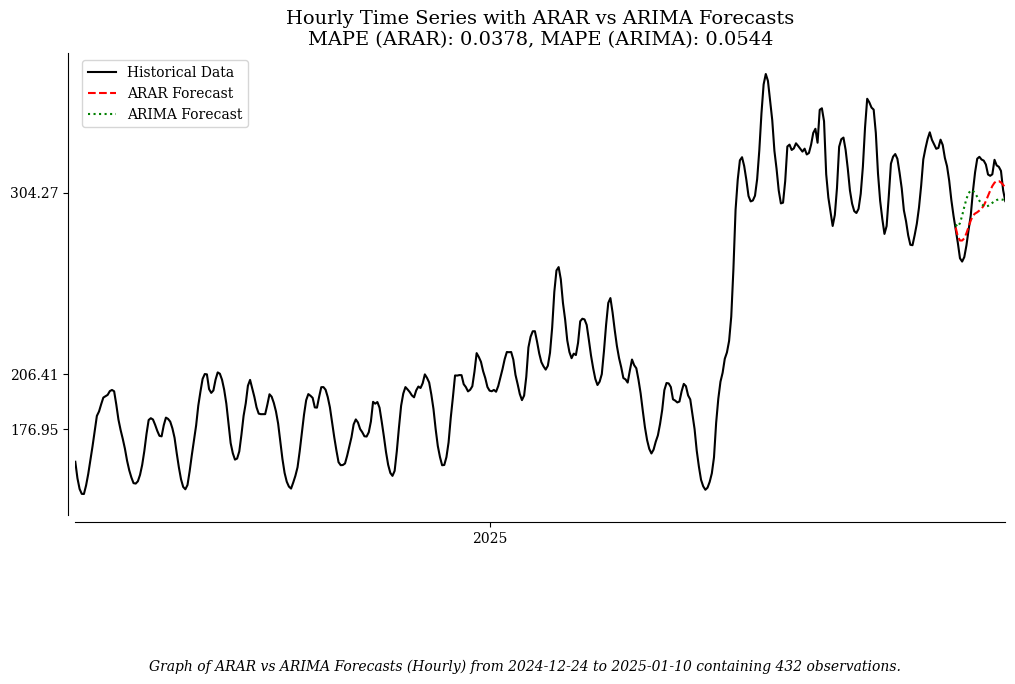

In [12]:
# Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf
from sklearn.metrics import mean_absolute_percentage_error
from matplotlib.dates import DateFormatter, YearLocator

# Set Global Matplotlib Style
plt.rcParams.update({
    "font.family": "serif",
    "axes.labelsize": 12,
    "axes.titlesize": 14
})

# Set Plot Style Function
def set_plot_style(ax, df, time_column, value_columns):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_position(("outward", 5))
    ax.spines["bottom"].set_position(("outward", 5))

    # X-Axis: Display years at 5-year intervals
    ax.xaxis.set_major_locator(YearLocator(5))
    ax.xaxis.set_major_formatter(DateFormatter("%Y"))
    ax.set_xlim(df[time_column].min(), df[time_column].max())

    # Y-Axis: Compute mean, 20%, and 80% dynamically
    all_values = np.concatenate([df[col].dropna().values for col in value_columns])
    y_20, y_mean, y_80 = np.percentile(all_values, [20, 50, 80])
    ax.set_yticks([y_20, y_mean, y_80])
    ax.set_yticklabels([f"{y_20:.2f}", f"{y_mean:.2f}", f"{y_80:.2f}"])

# Function to Add Captions to Graphs
def add_caption(ax, topic, start_time, end_time, num_obs):
    caption = f"Graph of {topic} from {start_time} to {end_time} containing {num_obs} observations."
    fig = ax.get_figure()
    fig.text(0.5, -0.15, caption, ha='center', fontsize=10, fontstyle='italic')


# Load dataset
data = pd.read_csv("ercot_load_data.csv", parse_dates=["date"], index_col="date")
y = data["values"]

# Resample to hourly frequency
y = y.resample("H").mean()

# Ensure consistent frequency
y = y.asfreq("H")

# Forecast Horizon (1 day = 24 steps for hourly data)
h = 24  
train, test = y.iloc[:-h], y.iloc[-h:]

# Apply differencing on training data for ARAR
z_train = np.diff(train)

# Compute autocorrelation and select reduced lags (powers of 2)
acf_vals = acf(z_train, nlags=20)
lags = [1, 2, 4, 8, 16]

# Fit ARAR model
arar_model = AutoReg(z_train, lags=lags, old_names=False).fit()

# Generate forecasts for next 24 steps
future_forecast_arar = arar_model.predict(start=len(z_train), end=len(z_train) + h - 1)

# Reverse differencing to reconstruct the original scale
y_forecast_arar = np.cumsum(future_forecast_arar) + train.iloc[-1]

# Create new time index for forecasts
forecast_index = pd.date_range(start=train.index[-1], periods=h+1, freq="H")[1:]

# Reindex to ensure consistency
y_forecast_arar = pd.Series(y_forecast_arar, index=forecast_index).asfreq("H")

# Compute MAPE for ARAR
mape_arar = mean_absolute_percentage_error(test, y_forecast_arar)
print(f"MAPE for ARAR: {mape_arar:.4f}")

# Fit ARIMA(2,1,2) model
arima_model = ARIMA(train, order=(2,1,2)).fit()

# Generate forecasts for next 24 steps
y_forecast_arima = arima_model.forecast(steps=h)

# Convert forecast index to match ARIMA output
y_forecast_arima.index = forecast_index

# Reindex to ensure consistency
y_forecast_arima = y_forecast_arima.asfreq("H")

# Compute MAPE for ARIMA
mape_arima = mean_absolute_percentage_error(test, y_forecast_arima)
print(f"MAPE for ARIMA: {mape_arima:.4f}")

# Combine Data for Plotting
df_plot = pd.DataFrame({
    "Time": y.index,
    "Historical Data": y,
    "ARAR Forecast": y_forecast_arar.reindex(y.index),
    "ARIMA Forecast": y_forecast_arima.reindex(y.index)
}).reset_index(drop=True)

# Plot Full Time Series with Forecasts
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(y.index, y, label="Historical Data", color="black", linestyle="-")
ax.plot(forecast_index, y_forecast_arar, label="ARAR Forecast", linestyle="--", color="red")
ax.plot(forecast_index, y_forecast_arima, label="ARIMA Forecast", linestyle=":", color="green")

# Highlight Peak Values
peak_arar = y_forecast_arar.max()
peak_arima = y_forecast_arima.max()
peak_date_arar = forecast_index[np.argmax(y_forecast_arar)]
peak_date_arima = forecast_index[np.argmax(y_forecast_arima)]



ax.set_title(f"Hourly Time Series with ARAR vs ARIMA Forecasts\nMAPE (ARAR): {mape_arar:.4f}, MAPE (ARIMA): {mape_arima:.4f}")
set_plot_style(ax, df_plot, "Time", ["Historical Data", "ARAR Forecast", "ARIMA Forecast"])
ax.legend()

# Add Caption
add_caption(ax, "ARAR vs ARIMA Forecasts (Hourly)", y.index.min().strftime("%Y-%m-%d"), y.index.max().strftime("%Y-%m-%d"), len(y))

plt.savefig("arar_vs_arima_hourly_forecast.png", dpi=300, bbox_inches="tight")
plt.show()
